<a href="https://colab.research.google.com/github/aifajar/eratani_ml_path/blob/main/Forecast_model_for_RHavg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
url = '/content/df_RHavg.csv'

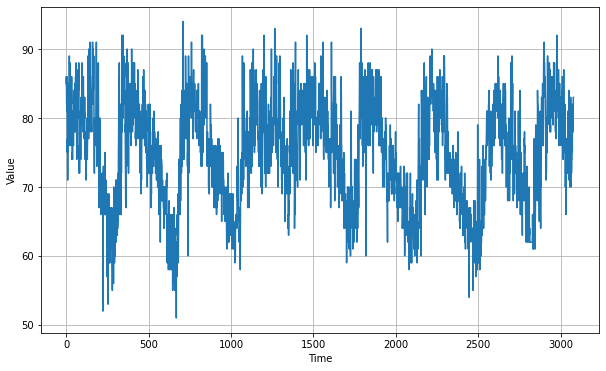

In [4]:
import csv
time_step = []
temps = []

with open(url) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2300
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2300,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
9/9 [==============================] - 8s 374ms/step - loss: 59.8579 - mae: 60.3579
Epoch 2/100
9/9 [==============================] - 4s 364ms/step - loss: 56.7804 - mae: 57.2804
Epoch 3/100
9/9 [==============================] - 4s 370ms/step - loss: 53.5079 - mae: 54.0079
Epoch 4/100
9/9 [==============================] - 4s 369ms/step - loss: 49.6214 - mae: 50.1214
Epoch 5/100
9/9 [==============================] - 3s 359ms/step - loss: 45.2345 - mae: 45.7345
Epoch 6/100
9/9 [==============================] - 3s 356ms/step - loss: 40.3602 - mae: 40.8602
Epoch 7/100
9/9 [==============================] - 4s 367ms/step - loss: 34.9600 - mae: 35.4600
Epoch 8/100
9/9 [==============================] - 3s 356ms/step - loss: 28.9755 - mae: 29.4755
Epoch 9/100
9/9 [==============================] - 4s 377ms/step - loss: 22.3331 - mae: 22.8331
Epoch 10/100
9/9 [==============================] - 4s 373ms/step - loss: 15.0228 - mae: 15.5208
Epoch 11/100
9/9 [=====================

(1e-08, 0.0001, 0.0, 60.0)

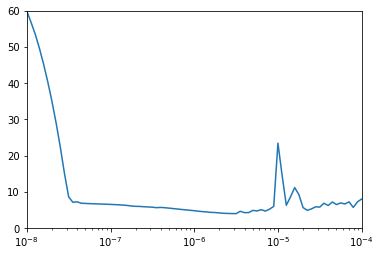

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
23/23 [==============================] - 7s 135ms/step - loss: 12.0866 - mae: 12.5720
Epoch 2/150
23/23 [==============================] - 3s 135ms/step - loss: 5.0232 - mae: 5.5024
Epoch 3/150
23/23 [==============================] - 3s 133ms/step - loss: 4.1518 - mae: 4.6268
Epoch 4/150
23/23 [==============================] - 3s 132ms/step - loss: 4.1473 - mae: 4.6223
Epoch 5/150
23/23 [==============================] - 3s 136ms/step - loss: 3.5513 - mae: 4.0222
Epoch 6/150
23/23 [==============================] - 3s 133ms/step - loss: 3.7465 - mae: 4.2199
Epoch 7/150
23/23 [==============================] - 3s 134ms/step - loss: 3.4701 - mae: 3.9410
Epoch 8/150
23/23 [==============================] - 3s 134ms/step - loss: 3.2575 - mae: 3.7267
Epoch 9/150
23/23 [==============================] - 3s 133ms/step - loss: 3.0765 - mae: 3.5436
Epoch 10/150
23/23 [==============================] - 3s 135ms/step - loss: 3.1602 - mae: 3.6283
Epoch 11/150
23/23 [=================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

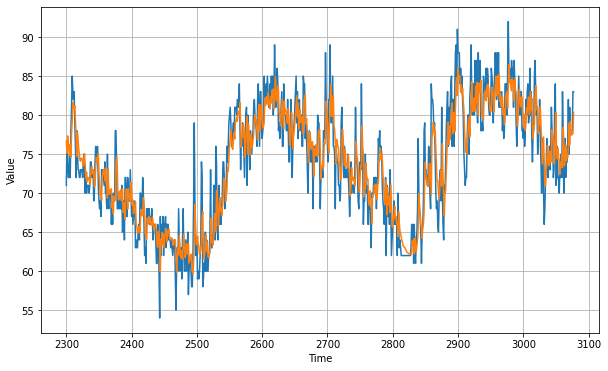

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.7000237

In [14]:
for n in range(28):
  print(rnn_forecast[n])

76.68042
75.148735
77.33294
76.488396
75.409164
74.826256
76.241974
74.593025
77.51727
79.1534
81.602684
81.08841
80.82107
81.20804
79.18645
77.40981
74.69762
77.75082
76.96543
75.6356
75.05462
74.21391
74.09166
74.47955
74.40338
74.293816
73.516045
74.47075
